# Evaluación

In [2]:
!pwd
!ls
%cd meleros/notebooks/
!pwd
!ls

/home/jovyan
environment.yml  meleros  work
/home/jovyan/meleros/notebooks
/home/jovyan/meleros/notebooks
1-eda-analisis-exploratorio.ipynb
2-rn_entrenamiento.ipynb
2-rnr_entrenamiento.ipynb
3-rn_evaluacion.ipynb
3-rnr_evaluacion.ipynb
dev
estudio3_1seg_hembra_labels_mapping.json
estudio3_1seg_labels_mapping.json
estudio3_1seg_macho_labels_mapping.json
history_estudio3_1seg_hembra_topology1.json
history_estudio3_1seg_hembra_topology2.json
history_estudio3_1seg_hembra_topology3.json
history_estudio3_1seg_macho_topology1.json
history_estudio3_1seg_macho_topology2.json
history_estudio3_1seg_macho_topology3.json
history_estudio3_1seg_topology1.json
history_estudio3_1seg_topology2.json
history_estudio3_1seg_topology3.json
model_estudio3_1seg_hembra_topology1.h5
model_estudio3_1seg_hembra_topology2.h5
model_estudio3_1seg_hembra_topology3.h5
model_estudio3_1seg_macho_topology1.h5
model_estudio3_1seg_macho_topology2.h5
model_estudio3_1seg_macho_topology3.h5
model_estudio3_1seg_topology1.h5
mod

In [6]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import json


import matplotlib.pyplot as plt

# Load h5 models for topology 1, 2 and 3
model_estudio3_1seg_topology1 = tf.keras.models.load_model('model_estudio3_1seg_topology1.h5')
model_estudio3_1seg_topology2 = tf.keras.models.load_model('model_estudio3_1seg_topology2.h5')
model_estudio3_1seg_topology3 = tf.keras.models.load_model('model_estudio3_1seg_topology3.h5')

# Load validation dataset
estudio3_1seg_val = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_val.csv')

# Asign comportamiento result to the results dataframe
resultados = pd.DataFrame()
resultados['Comportamiento'] = estudio3_1seg_val['Comportamiento']

# Use the models to predict the validation dataset
X_val = estudio3_1seg_val.drop(columns=['Comportamiento', 'Sexo'])
y_val = pd.get_dummies(estudio3_1seg_val['Comportamiento'])
labels_mapping = y_val.columns.tolist()  # Save the mapping
X_val_scaled = StandardScaler().fit_transform(X_val)

# Compare traines label mappings with current mapping
with open('estudio3_1seg_labels_mapping.json', 'r') as f:
    train_labels_mapping = json.load(f)
    assert train_labels_mapping == labels_mapping

resultados['Topology1'] = model_estudio3_1seg_topology1.predict(X_val_scaled).argmax(axis=1)
resultados['Topology2'] = model_estudio3_1seg_topology2.predict(X_val_scaled).argmax(axis=1)
resultados['Topology3'] = model_estudio3_1seg_topology3.predict(X_val_scaled).argmax(axis=1)

# Convert predictions results to the original labels
def indices_to_labels(indices, mapping):
    return [mapping[i] for i in indices]

# Convert predictions to labels
resultados['Topology1_Labels'] = indices_to_labels(resultados['Topology1'], labels_mapping)
resultados['Topology2_Labels'] = indices_to_labels(resultados['Topology2'], labels_mapping)
resultados['Topology3_Labels'] = indices_to_labels(resultados['Topology3'], labels_mapping)

# Save the results to a csv file
resultados.to_csv('resultados_modelos_estudio3.csv', index=False)

219/219 [==============================] - 0s 2ms/step


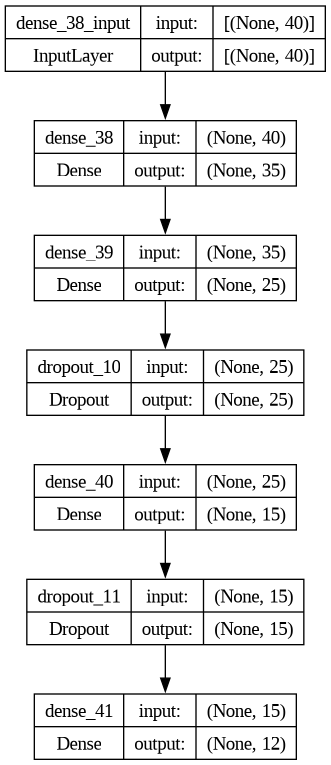

In [7]:
from tensorflow.keras.utils import plot_model

# Save the model structure.

# Plot the model structure
plot_model(model_estudio3_1seg_topology1, to_file='model_structure.png', show_shapes=True)
plot_model(model_estudio3_1seg_topology2, to_file='model_structure2.png', show_shapes=True)
plot_model(model_estudio3_1seg_topology3, to_file='model_structure3.png', show_shapes=True)